In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
%matplotlib inline

Training Size:  3662
Testing Size:  1928


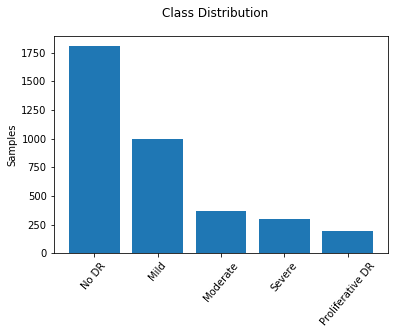

In [15]:
# Dataset Analysis

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
class_labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

print("Training Size: ", len(train_data))
print("Testing Size: ", len(test_data))

plt.suptitle("Class Distribution")
plt.bar(range(5), train_data.diagnosis.value_counts())
plt.xticks(range(5), class_labels, rotation=50)
plt.ylabel("Samples")
plt.show()

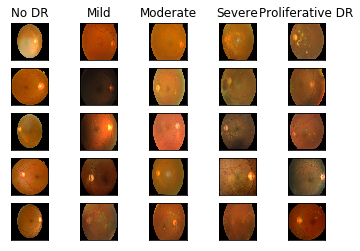

In [16]:
# Some Visualizations
im_shape = (128, 128, 3)

def load_image(path, dim=None):
    im = Image.open(path)
    if dim is not None:
        im = im.resize(dim,resample=Image.LANCZOS)
#     im.convert(mode="RGB")
    return np.array(im)

num_classes = len(class_labels)
num_samples = 5
figure = plt.figure()

for i, label in enumerate(class_labels):
    samples = train_data.loc[train_data.diagnosis==i, 'id_code'].sample(num_samples,).reset_index(drop=True)
    for j in range(num_samples):
        im = load_image("../data/train_images/" + str(samples[j]) + ".png", (im_shape[0], im_shape[1]))
        fig_ax = figure.add_subplot(num_classes, num_classes, i+5*j+1)
        fig_ax.set_xticks([], [])
        fig_ax.set_yticks([], [])
        if j==0:
            fig_ax.set_title(class_labels[i])
        fig_ax.imshow(im)
        
plt.show()

In [17]:
%%time
s = load_image("../data/train_images/" + str(train_data.loc[2].id_code) + ".png", (128,128))

CPU times: user 106 ms, sys: 24 µs, total: 106 ms
Wall time: 105 ms


In [18]:
%%time
images = np.empty(shape=(len(train_data.index), im_shape[0], im_shape[1], 3))
labels = np.empty(shape=(len(train_data.index),))
for i, row in tqdm(train_data.iterrows()):
    im = load_image("../data/train_images/" + str(row.id_code) + ".png", (im_shape[0], im_shape[1]))
    images[i] = im
    labels[i] = row.diagnosis 

validation_images = images[:int(len(images)*0.2)]
validation_labels = labels[:int(len(images)*0.2)]
train_images = images[int(len(images)*0.2):]
train_labels = labels[int(len(images)*0.2):]
print(train_images.shape, train_labels.shape)
print(validation_images.shape, validation_labels.shape)
del(images)

3662it [05:55, 10.58it/s]

(2930, 128, 128, 3) (2930,)
(732, 128, 128, 3) (732,)
CPU times: user 5min 50s, sys: 3.77 s, total: 5min 54s
Wall time: 5min 55s


In [19]:
# I have images. I have classes. Let's train a basic network. Let's see.
model = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
2930/2930 [==============================] - 2s 617us/sample - loss: 578.9731 - acc: 0.5727
Epoch 2/10
2930/2930 [==============================] - 2s 570us/sample - loss: 369.2006 - acc: 0.6239
Epoch 3/10
2930/2930 [==============================] - 2s 559us/sample - loss: 316.6985 - acc: 0.6379
Epoch 4/10
2930/2930 [==============================] - 2s 549us/sample - loss: 242.8327 - acc: 0.6372
Epoch 5/10
2930/2930 [==============================] - 2s 559us/sample - loss: 273.4913 - acc: 0.6485
Epoch 6/10
2930/2930 [==============================] - 2s 559us/sample - loss: 319.4287 - acc: 0.6406
Epoch 7/10
2930/2930 [==============================] - 2s 546us/sample - loss: 221.5577 - acc: 0.6515
Epoch 8/10
2930/2930 [==============================] - 2s 538us/sample - loss: 222.5009 - acc: 0.6618
Epoch 9/10
2930/2930 [==============================] - 2s 588us/sample - loss: 172.7028 - acc: 0.6792
Epoch 10/10
2930/2930 [==============================] - 2s 606us/sample 

In [21]:
model.evaluate(validation_images, validation_labels)

732/732 [==============================] - 0s 229us/sample - loss: 166.1225 - acc: 0.7199


[166.12251940451034, 0.7199454]

In [63]:
# test
images = np.empty(shape=(len(test_data.index), im_shape[0], im_shape[1], 3))
for i, row in test_data.iterrows():
    im = load_image("../data/test_images/" + str(row.id_code) + ".png", (im_shape[0], im_shape[1]))
    images[i] = im
    if i%100 == 0:
        print(i)
        
test_images = images

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [65]:
predictions = model.predict(test_images)

In [107]:
# create submission
test_data.reset_index()
with open("submissions.csv", "w") as f:
    f.write("id_code, diagnosis\n")
    for i in range(len(predictions)):
        f.write(test_data.id_code[i] + "," + str(np.argmax(predictions[i])) + "\n")

In [103]:
test_data.id_code[0]

'0005cfc8afb6'

In [23]:
model.save("basic.h5")

In [ ]:
newmodel = tf